In [1]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [2]:
model = VGG19(include_top=False,weights='imagenet')
model.trainable = False
#model.summary()

target_height=150
target_width=280

content_img_path='content1.JPG' 
style_img_path='style3.jpg' 

target_size=(target_height,target_width)

In [3]:
def load_and_process(image_path):
    img = load_img(image_path,target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    return img


def deprocess(img):
    x = img
    # mean value of R G B for each pixel in imagenet dataset
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68 
    # reverses the array BGR->RGB
    x = x[:,:,::-1]
    x= np.clip(x,0,255).astype('uint8')
    return x


def show_img(image,save_image=True):
    if len(image.shape)==4:
        image = np.squeeze(image,axis=0)
    image = deprocess(image)

    if save_image:
        image = Image.fromarray(image)
        image.save("Saved_Image.jpg")
    plt.imshow(image)
    return

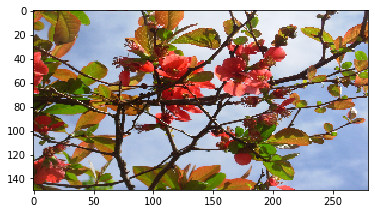

In [4]:
show_img(load_and_process(content_img_path))

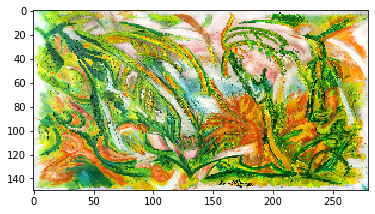

In [5]:
show_img(load_and_process(style_img_path))

Ascending layers in most convolutional networks such as VGG have increasingly larger receptive fields. As this receptive field grows, more large-scale characteristics of the input image are preserved. Because of this, multiple layers should be selected for “style” to incorporate both local and global stylistic qualities.

In [6]:
Content_layer='block5_pool'

Style_layer = [
               ('block1_conv2'),
               ('block2_conv1'),
               ('block2_conv2'),
               ('block3_conv1')
]


content_model=Model(inputs = model.input, outputs = model.get_layer(Content_layer).output)

In [7]:
# 4 models for style image as there are 4 layers
style_model = []
for layer in Style_layer:
    style_model.append( Model(inputs = model.input, outputs=model.get_layer(layer).output))


# content loss
The purpose of the content loss is to make sure that the generated image x retains some of the “global” characteristics of the content image, p.  This means that shapes such as house, face, ears, and eyes ought to be recognizable. To achieve this, the content loss function is defined as the mean squared error between the feature representations of p and x, respectively, at a given layer l.

![](http:/miro.medium.com/max/1200/1*wsjx67USrpxldQ7kSR7JWg@2x.png)

In [8]:
def content_cost(content_img,generated_img):
    a_C = content_model(content_img)  # getting feature representations 
    a_G = content_model(generated_img)  # getting feature representations
    c_loss = tf.reduce_mean(tf.square(a_C - a_G))
    return c_loss

# Style Loss
On the other hand, the style loss is designed to preserve stylistic characteristics of the style image, a. Rather than using the difference between feature representations, the authors use the the difference between Gram matrices from selected layers, where the Gram matrix is defined as:
![](http://miro.medium.com/max/600/1*0kw-0Bnbjf7Z5wBEGYgGOg@2x.png)

The Gram matrix is a square matrix that contains the dot products between each vectorized filter in layer l. The Gram matrix can therefore be thought of as a non-normalized correlation matrix for filters in layer l

In [9]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    A = tf.reshape(A,[-1,n_C])
    n = tf.shape(A)[0]
    gmatrix = tf.matmul(A,A,transpose_a=True)
    
    return gmatrix/tf.cast(n,tf.float32)

Then, we can define the loss contribution from layer l as

![](https://miro.medium.com/max/1200/1*BfgT5D4w1BRwtRnRXTd_lg@2x.png)

where A is the Gram matrix for the style image a and G is the Gram matrix for the generated image x.

To create a smooth blending between these different layers, we can assign a weight w to each layer, and define the total style loss as:

![](https://miro.medium.com/max/904/1*zRmd9QVlxb4gPX5XjLlLyA@2x.png)

In [10]:
style_layer_weights = [1,0.5,0.3,0.1]


def style_cost(style_img,generated_img):
    s_cost=0
    for i,s_model in enumerate(style_model):
        a_S=s_model(style_img)
        a_G=s_model(generated_img)
        GS=gram_matrix(a_S)
        GG=gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        s_cost+= style_layer_weights[i]*current_cost
    return s_cost

total loss:

![](https://miro.medium.com/max/1400/1*Ov8PoO74MBoS_0bt5dDzgw@2x.png)

In [11]:

generated_images = []
total_loss = 0
iter_num = []
cost = []
s_cost = []
c_cost = []


def training(content_img_path, style_img_path, alpha=20.0, beta=400.0, iterations=2000): 
    content_img = load_and_process(content_img_path)
    style_img = load_and_process(style_img_path)

    # for faster and better results - starting generated to be content image (instead of random noise input)
    generated = tf.Variable(content_img, dtype=tf.float64)
    opt = tf.optimizers.Adam(learning_rate=6.0)
    min_cost = 1e20 + 0.1
    best_img = None

    for i in range(iterations):
        with tf.GradientTape() as tape:
            content_loss = content_cost(content_img, generated)
            style_loss = style_cost(style_img, generated)
            total_loss = alpha * content_loss + beta * style_loss

            grads = tape.gradient(total_loss, generated)
            opt.apply_gradients([(grads, generated)])
        iter_num.append(i)
        cost.append(total_loss)
        s_cost.append(style_loss)
        c_cost.append(content_loss)

        if total_loss < min_cost:
            min_cost = total_loss
            best_img = generated.numpy()
        if i % 20 == 0:
            generated_images.append(generated.numpy())
            print("Iteration: {},  Cost: {}, Style Cost: {}, Content Cost: {}".format(i + 1, total_loss, style_loss, content_loss))
            show_img(generated.numpy())
            plt.show()
    return best_img, generated_images


Iteration: 1,  Cost: 25760584.0, Style Cost: 2576058368.0, Content Cost: 0.0


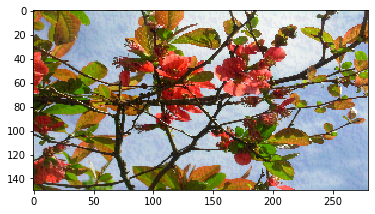

Iteration: 21,  Cost: 942695.125, Style Cost: 83874432.0, Content Cost: 10.395079612731934


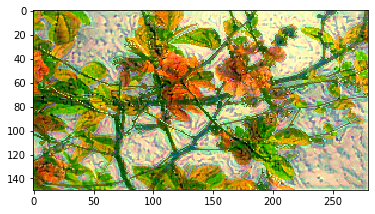

Iteration: 41,  Cost: 255113.03125, Style Cost: 20112326.0, Content Cost: 5.398978233337402


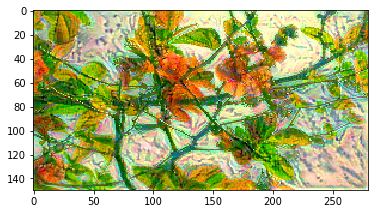

Iteration: 61,  Cost: 136480.28125, Style Cost: 10540019.0, Content Cost: 3.108008861541748


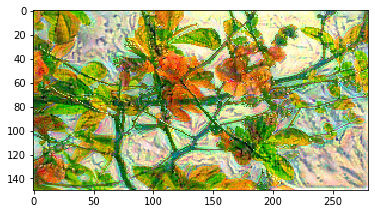

Iteration: 81,  Cost: 91359.140625, Style Cost: 6946614.0, Content Cost: 2.189300298690796


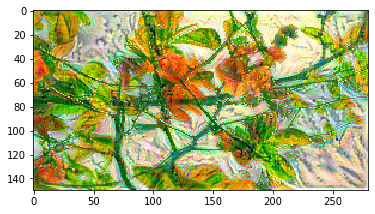

In [12]:
# alpha * content_loss + beta * style_loss
best_img, img_array = training(content_img_path,style_img_path, alpha=10000, beta=0.01, iterations=100)

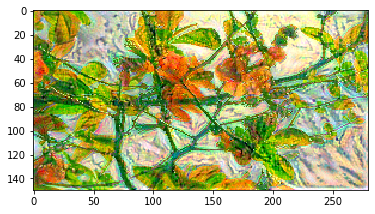

In [13]:
show_img(best_img)